<h2>FreshCart Churn Prediction - Model Optimizasyonu</h2>
 
<h4>
    <b>
        Zero2End Machine Learning Bootcamp - Bitirme Projesi
    </b>
</h4>

<h3>
    Notebook İçeriği
</h3>

<ol>
    <li>Gelişmiş Özellikleri Yükle</li>
    <li>LightGBM Temel Modeli</li>
    <li>XGBoost Temel Modeli</li>
    <li>CatBoost Temel Modeli</li>
    <li>Optuna ile Hiperparametre Optimizasyonu</li>
    <li>Model Karşılaştırması</li>
    <li>En İyi Modelin Seçilmesi</li>
</ol>

<hr>

In [48]:
# Kütüphane importları
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys
import json
import os
import pickle
from pathlib import Path

import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import joblib

In [4]:
from config import PROCESSED_DATA_DIR, MODEL_DIR, RANDOM_STATE

print("Kütüphaneler başarıyla içe aktarıldı!")

Kütüphaneler başarıyla içe aktarıldı!


In [3]:
# src'yi yola ekle
sys.path.append('../src')

In [2]:
# Ayarlar
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
optuna.logging.set_verbosity(optuna.logging.WARNING)

<h2>
    1-Gelişmiş Özellikleri Yükle
</h2>

In [5]:
# Gelişmiş özellikleri yükle
print("Gelişmiş özellikler yükleniyor...")

final_features = pd.read_parquet(
    PROCESSED_DATA_DIR / 'final_features_advanced.parquet'
)

Gelişmiş özellikler yükleniyor...


In [6]:
# Özellik meta verisini yükle
with open(PROCESSED_DATA_DIR / 'feature_metadata.json', 'r') as f:
    feature_metadata = json.load(f)

print(f"Özellikler yüklendi: {final_features.shape}")
print(f"   Toplam özellik sayısı: {feature_metadata['total_features']}")
print(f"   Müşteri kaybı oranı: {final_features['is_churn'].mean():.2%}")

Özellikler yüklendi: (206209, 54)
   Toplam özellik sayısı: 52
   Müşteri kaybı oranı: 30.64%


In [7]:
# Eğitim ve test verisini ayır
feature_cols = [col for col in final_features.columns if col not in ['user_id', 'is_churn']]

X = final_features[feature_cols].fillna(0)
y = final_features['is_churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"\nVeri seti ayrımı:")
print(f"   Eğitim: {X_train.shape} - Kayıp Oranı: {y_train.mean():.2%}")
print(f"   Test:  {X_test.shape} - Kayıp Oranı: {y_test.mean():.2%}")


Veri seti ayrımı:
   Eğitim: (164967, 52) - Kayıp Oranı: 30.64%
   Test:  (41242, 52) - Kayıp Oranı: 30.64%


<h2>
    2-LightGBM Temel Modeli
</h2>

In [8]:
print("\n" + "="*80)
print("MODEL 1: LightGBM Temel Modeli")
print("="*80)


MODEL 1: LightGBM Temel Modeli


In [9]:
# Varsayılan parametreler
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': RANDOM_STATE,
    'is_unbalance': True
}

In [10]:
# Veri setini oluştur
lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [11]:
# Eğit
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['eğitim', 'doğrulama'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)

Training until validation scores don't improve for 50 rounds
[50]	eğitim's auc: 0.768796	doğrulama's auc: 0.766662
[100]	eğitim's auc: 0.773986	doğrulama's auc: 0.767943
[150]	eğitim's auc: 0.778281	doğrulama's auc: 0.768125
[200]	eğitim's auc: 0.782848	doğrulama's auc: 0.768285
Early stopping, best iteration is:
[194]	eğitim's auc: 0.782401	doğrulama's auc: 0.768321


In [12]:
# Tahminler
y_pred_lgb = (lgb_model.predict(X_test) > 0.5).astype(int)
y_pred_proba_lgb = lgb_model.predict(X_test)

In [13]:
# Metrikler
lgb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_lgb),
    'precision': precision_score(y_test, y_pred_lgb),
    'recall': recall_score(y_test, y_pred_lgb),
    'f1': f1_score(y_test, y_pred_lgb),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_lgb)
}

In [15]:
print(f"\nLightGBM Temel Model Sonuçları:")
print(f"   Doğruluk (Accuracy):  {lgb_metrics['accuracy']:.4f}")
print(f"   Kesinlik (Precision): {lgb_metrics['precision']:.4f}")
print(f"   Duyarlılık (Recall):    {lgb_metrics['recall']:.4f}")
print(f"   F1-Skoru:  {lgb_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {lgb_metrics['roc_auc']:.4f}")


LightGBM Temel Model Sonuçları:
   Doğruluk (Accuracy):  0.6693
   Kesinlik (Precision): 0.4761
   Duyarlılık (Recall):    0.7883
   F1-Skoru:  0.5937
   ROC-AUC:   0.7683


<h2>
    3-XGBoost Temel Modeli
</h2>

In [16]:
print("\n" + "="*80)
print("MODEL 2: XGBoost Temel Modeli")
print("="*80)


MODEL 2: XGBoost Temel Modeli


In [17]:
# Varsayılan parametreler
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'scale_pos_weight': (y_train == 0).sum() / (y_train == 1).sum()
}

In [18]:
# DMatrix oluştur
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [19]:
# Eğit
xgb_model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'eğitim'), (dtest, 'doğrulama')],
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	eğitim-auc:0.74159	doğrulama-auc:0.74090
[50]	eğitim-auc:0.77750	doğrulama-auc:0.76783
[100]	eğitim-auc:0.78947	doğrulama-auc:0.76750
[109]	eğitim-auc:0.79146	doğrulama-auc:0.76755


In [20]:
# Tahminler
y_pred_proba_xgb = xgb_model.predict(dtest)
y_pred_xgb = (y_pred_proba_xgb > 0.5).astype(int)

In [21]:
# Metrikler
xgb_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_xgb),
    'precision': precision_score(y_test, y_pred_xgb),
    'recall': recall_score(y_test, y_pred_xgb),
    'f1': f1_score(y_test, y_pred_xgb),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_xgb)
}

In [22]:
print(f"\nXGBoost Temel Model Sonuçları:")
print(f"   Doğruluk (Accuracy):  {xgb_metrics['accuracy']:.4f}")
print(f"   Kesinlik (Precision): {xgb_metrics['precision']:.4f}")
print(f"   Duyarlılık (Recall):    {xgb_metrics['recall']:.4f}")
print(f"   F1-Skoru:  {xgb_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {xgb_metrics['roc_auc']:.4f}")


XGBoost Temel Model Sonuçları:
   Doğruluk (Accuracy):  0.6716
   Kesinlik (Precision): 0.4781
   Duyarlılık (Recall):    0.7840
   F1-Skoru:  0.5940
   ROC-AUC:   0.7675


<h2>
    4-CatBoost Temel Modeli
</h2>

In [23]:
print("\n" + "="*80)
print("MODEL 3: CatBoost Temel Modeli")
print("="*80)


MODEL 3: CatBoost Temel Modeli


In [24]:
# CatBoost modeli
cat_model = cb.CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='Logloss',
    eval_metric='AUC',
    random_state=RANDOM_STATE,
    verbose=50,
    early_stopping_rounds=50,
    auto_class_weights='Balanced'
)

In [25]:
# Eğit
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=50
)

0:	test: 0.7455825	best: 0.7455825 (0)	total: 417ms	remaining: 6m 56s
50:	test: 0.7641003	best: 0.7641003 (50)	total: 4.01s	remaining: 1m 14s
100:	test: 0.7661977	best: 0.7661977 (100)	total: 7.4s	remaining: 1m 5s
150:	test: 0.7674040	best: 0.7674040 (150)	total: 11.7s	remaining: 1m 5s
200:	test: 0.7676119	best: 0.7676926 (177)	total: 13.9s	remaining: 55.4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.7676926158
bestIteration = 177

Shrink model to first 178 iterations.


In [26]:
# Tahminler
y_pred_proba_cat = cat_model.predict_proba(X_test)[:, 1]
y_pred_cat = cat_model.predict(X_test)

In [27]:
# Metrikler
cat_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_cat),
    'precision': precision_score(y_test, y_pred_cat),
    'recall': recall_score(y_test, y_pred_cat),
    'f1': f1_score(y_test, y_pred_cat),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_cat)
}

In [28]:
print(f"\nCatBoost Temel Model Sonuçları:")
print(f"   Doğruluk (Accuracy):  {cat_metrics['accuracy']:.4f}")
print(f"   Kesinlik (Precision): {cat_metrics['precision']:.4f}")
print(f"   Duyarlılık (Recall):    {cat_metrics['recall']:.4f}")
print(f"   F1-Skoru:  {cat_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {cat_metrics['roc_auc']:.4f}")


CatBoost Temel Model Sonuçları:
   Doğruluk (Accuracy):  0.6718
   Kesinlik (Precision): 0.4783
   Duyarlılık (Recall):    0.7829
   F1-Skoru:  0.5938
   ROC-AUC:   0.7677


<h2>
    5-Optuna ile Hiperparametre Optimizasyonu
</h2>

In [29]:
# Optimizasyon için en iyi temel modeli seç
baseline_comparison = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'CatBoost'],
    'F1-Skoru': [lgb_metrics['f1'], xgb_metrics['f1'], cat_metrics['f1']],
    'ROC-AUC': [lgb_metrics['roc_auc'], xgb_metrics['roc_auc'], cat_metrics['roc_auc']]
})

print("\n" + "="*80)
print("TEMEL MODEL KARŞILAŞTIRMASI")
print("="*80)
display(baseline_comparison)


TEMEL MODEL KARŞILAŞTIRMASI


,Model,F1-Skoru,ROC-AUC
0,LightGBM,0.593665,0.768321
1,XGBoost,0.593963,0.767514
2,CatBoost,0.593824,0.767693


In [31]:
# En iyi skora göre istatistiksel kazananı belirle
statistical_winner = baseline_comparison.loc[baseline_comparison['F1-Skoru'].idxmax(), 'Model']

print(f"\nİstatistiksel Kazanan: {statistical_winner}")


İstatistiksel Kazanan: XGBoost


In [34]:
# STRATEJİK KARAR:
# Temel model skorları çok yakın (LGBM: 0.593665, XGBoost: 0.593963, CatBoost: 0.593824).
# Optimizasyon hızı ve dağıtım kolaylığı nedeniyle LightGBM'i seçiyoruz.

target_model = "LightGBM"

if statistical_winner != target_model:
    print(f"Not: {statistical_winner} biraz daha yüksek bir temel skora sahip olsa da,")
    print(f"   hiperparametre optimizasyonu için {target_model} ile devam edeceğiz.")
    print(f"   Sebep: Daha hızlı eğitim süresi ve verimli optimizasyon yeteneği.")
else:
    print(f"Seçilen {target_model}. Optimizasyon ile devam ediliyor...")

Not: XGBoost biraz daha yüksek bir temel skora sahip olsa da,
   hiperparametre optimizasyonu için LightGBM ile devam edeceğiz.
   Sebep: Daha hızlı eğitim süresi ve verimli optimizasyon yeteneği.


In [37]:
# Sonraki adımlarda tutarlılığı sağlamak için değişkeni ayarla
best_model_name = target_model

print(f"\nSeçilen model: {best_model_name}")
print(f"Hiperparametre optimizasyonu için bu model kullanılacak...")


Seçilen model: LightGBM
Hiperparametre optimizasyonu için bu model kullanılacak...


In [38]:
# LightGBM Optuna optimizasyonu
def objective_lgb(trial):
    """LightGBM için Optuna hedef fonksiyonu (Dengesiz Veri için Optimize Edilmiştir)"""
    
    # Müşteri kaybı oranındaki dengesizlik için ağırlık hesapla
    # (Negatif Örnek Sayısı / Pozitif Örnek Sayısı)
    pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'n_jobs': -1,  # Tüm işlemcileri kullan
        'random_state': RANDOM_STATE,
        'verbose': -1,
        
        # Dengesiz veri seti ayarı (is_unbalance yerine bunu kullanıyoruz)
        'scale_pos_weight': pos_weight,
        
        # Optuna ile optimize edilecek hiperparametreler
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        
        # Regülarizasyon (aşırı öğrenmeyi önlemek için eklenebilir)
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True)
    }
    
    # Modeli Çapraz Doğrulama (Cross-validation) ile değerlendir
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    
    for train_idx, valid_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]
        
        # LightGBM Veri Seti formatı
        dtrain = lgb.Dataset(X_tr, label=y_tr)
        dvalid = lgb.Dataset(X_val, label=y_val, reference=dtrain)
        
        # Modeli eğit
        model = lgb.train(
            params,
            dtrain,
            num_boost_round=1000,
            valid_sets=[dvalid],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0) # Çıktı karmaşasını önlemek için devre dışı bırakıldı
            ]
        )
        
        # Tahmin ve Puanlama
        preds = model.predict(X_val)
        score = roc_auc_score(y_val, preds)
        scores.append(score)
    
    # Ortalama AUC skorunu döndür
    return np.mean(scores)

In [39]:
print("\nOptuna hiperparametre optimizasyonu başlatılıyor...")
print("Bu işlem 10-15 dakika sürebilir...\n")

study = optuna.create_study(direction='maximize')
study.optimize(objective_lgb, n_trials=50, show_progress_bar=True)

print(f"\nOptimizasyon tamamlandı!")
print(f"   En iyi AUC: {study.best_value:.4f}")
print(f"   En iyi parametreler:")
for key, value in study.best_params.items():
    print(f"      {key}: {value}")


Optuna hiperparametre optimizasyonu başlatılıyor...
Bu işlem 10-15 dakika sürebilir...



  0%|          | 0/50 [00:00<?, ?it/s]


Optimizasyon tamamlandı!
   En iyi AUC: 0.7672
   En iyi parametreler:
      num_leaves: 54
      learning_rate: 0.016821435662367816
      feature_fraction: 0.5228724809297342
      bagging_fraction: 0.7426607684849414
      bagging_freq: 2
      min_child_samples: 33
      max_depth: 7
      lambda_l1: 1.9579569798839285
      lambda_l2: 3.761799724224957e-05


In [40]:
# Train final model with best params
print("\nTraining final model with optimized parameters...")

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

best_params = study.best_params
best_params.update({
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbose': -1,
    'random_state': RANDOM_STATE,
    'scale_pos_weight': pos_weight 
})

lgb_train = lgb.Dataset(X_train, y_train)
lgb_valid = lgb.Dataset(X_test, y_test, reference=lgb_train)

final_model = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)


Training final model with optimized parameters...
Training until validation scores don't improve for 50 rounds
[50]	train's auc: 0.767046	valid's auc: 0.764856
[100]	train's auc: 0.770104	valid's auc: 0.766622
[150]	train's auc: 0.772838	valid's auc: 0.767709
[200]	train's auc: 0.775365	valid's auc: 0.768444
[250]	train's auc: 0.77762	valid's auc: 0.768923
[300]	train's auc: 0.779843	valid's auc: 0.769178
[350]	train's auc: 0.782135	valid's auc: 0.769378
[400]	train's auc: 0.784341	valid's auc: 0.769499
[450]	train's auc: 0.786655	valid's auc: 0.769534
[500]	train's auc: 0.788689	valid's auc: 0.769506
Early stopping, best iteration is:
[453]	train's auc: 0.786783	valid's auc: 0.769551


In [41]:
# Final predictions
y_pred_final = (final_model.predict(X_test) > 0.5).astype(int)
y_pred_proba_final = final_model.predict(X_test)

In [42]:
# Final metrics
final_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_final),
    'precision': precision_score(y_test, y_pred_final),
    'recall': recall_score(y_test, y_pred_final),
    'f1': f1_score(y_test, y_pred_final),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_final)
}

In [43]:
print(f"\nFinal Optimized Model Results:")
print(f"   Accuracy:  {final_metrics['accuracy']:.4f}")
print(f"   Precision: {final_metrics['precision']:.4f}")
print(f"   Recall:    {final_metrics['recall']:.4f}")
print(f"   F1-Score:  {final_metrics['f1']:.4f}")
print(f"   ROC-AUC:   {final_metrics['roc_auc']:.4f}")


Final Optimized Model Results:
   Accuracy:  0.6715
   Precision: 0.4781
   Recall:    0.7861
   F1-Score:  0.5945
   ROC-AUC:   0.7696


<h2>
    6-Model Karşılaştırması - Temel vs Optimize Edilmiş
</h2>

In [44]:
# Karşılaştırma tablosu
comparison_df = pd.DataFrame({
    'Model': ['LightGBM Temel', 'XGBoost Temel', 'CatBoost Temel', 'LightGBM Optimize Edilmiş'],
    'Kesinlik (Precision)': [lgb_metrics['precision'], xgb_metrics['precision'], 
                             cat_metrics['precision'], final_metrics['precision']],
    'Duyarlılık (Recall)': [lgb_metrics['recall'], xgb_metrics['recall'], 
                            cat_metrics['recall'], final_metrics['recall']],
    'F1-Skoru': [lgb_metrics['f1'], xgb_metrics['f1'], 
                 cat_metrics['f1'], final_metrics['f1']],
    'ROC-AUC': [lgb_metrics['roc_auc'], xgb_metrics['roc_auc'], 
                cat_metrics['roc_auc'], final_metrics['roc_auc']]
})

print("\n" + "="*80)
print("NİHAİ MODEL KARŞILAŞTIRMASI")
print("="*80)
display(comparison_df)


NİHAİ MODEL KARŞILAŞTIRMASI


,Model,Kesinlik (Precision),Duyarlılık (Recall),F1-Skoru,ROC-AUC
0,LightGBM Temel,0.476104,0.788320,0.593665,0.768321
1,XGBoost Temel,0.478091,0.783968,0.593963,0.767514
2,CatBoost Temel,0.478294,0.782939,0.593824,0.767693
3,LightGBM Optimize Edilmiş,0.478056,0.786104,0.594548,0.769551


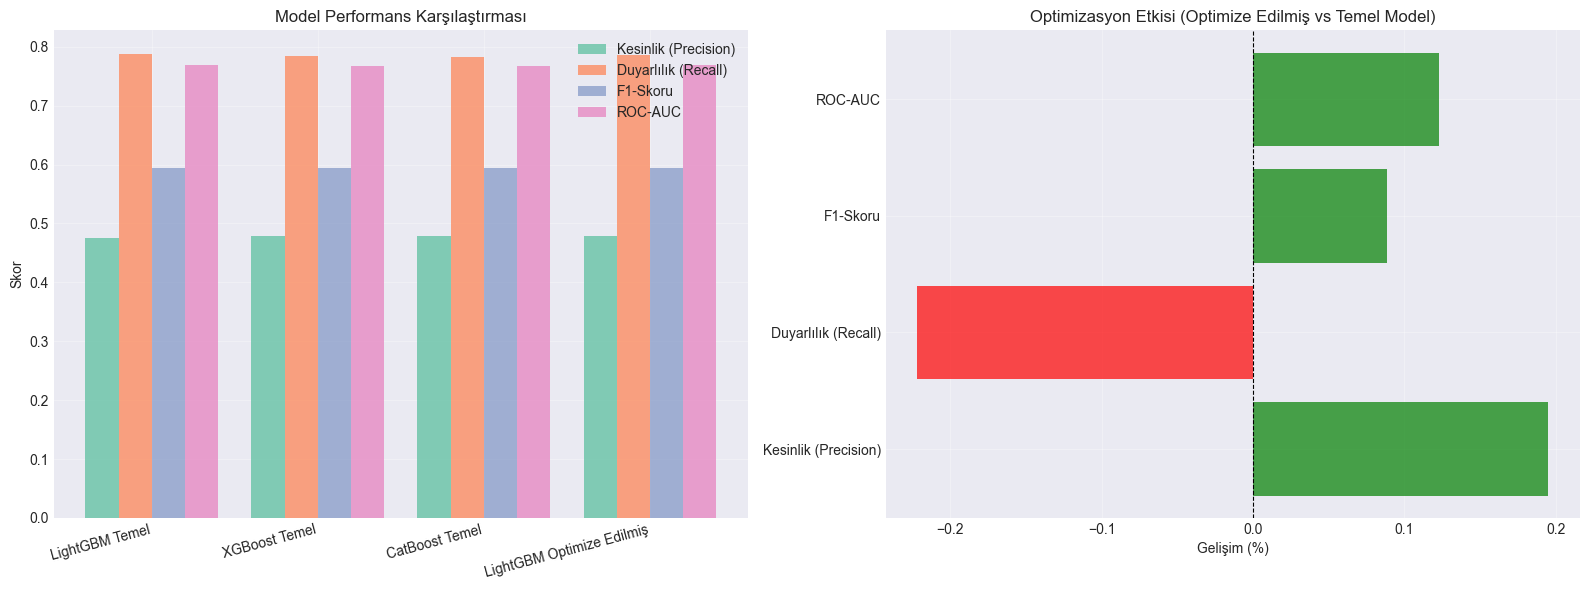

In [45]:
# Görselleştirme
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Metriklerin karşılaştırılması
ax = axes[0]
x = np.arange(len(comparison_df))
width = 0.2

ax.bar(x - 1.5*width, comparison_df['Kesinlik (Precision)'], width, label='Kesinlik (Precision)', alpha=0.8)
ax.bar(x - 0.5*width, comparison_df['Duyarlılık (Recall)'], width, label='Duyarlılık (Recall)', alpha=0.8)
ax.bar(x + 0.5*width, comparison_df['F1-Skoru'], width, label='F1-Skoru', alpha=0.8)
ax.bar(x + 1.5*width, comparison_df['ROC-AUC'], width, label='ROC-AUC', alpha=0.8)

ax.set_ylabel('Skor')
ax.set_title('Model Performans Karşılaştırması')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax.legend()
ax.grid(True, alpha=0.3)

# Gelişim grafiği
ax = axes[1]
improvement = (comparison_df.iloc[-1][['Kesinlik (Precision)', 'Duyarlılık (Recall)', 'F1-Skoru', 'ROC-AUC']] - 
               comparison_df.iloc[0][['Kesinlik (Precision)', 'Duyarlılık (Recall)', 'F1-Skoru', 'ROC-AUC']]) * 100

colors = ['green' if x > 0 else 'red' for x in improvement.values]
ax.barh(range(len(improvement)), improvement.values, color=colors, alpha=0.7)
ax.set_yticks(range(len(improvement)))
ax.set_yticklabels(improvement.index)
ax.set_xlabel('Gelişim (%)')
ax.set_title('Optimizasyon Etkisi (Optimize Edilmiş vs Temel Model)')
ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../plots/11_model_optimization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

<h2>
    Grafik Yorumu: Model Performansı ve Optimizasyon Sonuçları
</h2>

<p>
    Bu bölümde, üç farklı temel modelin (LightGBM, XGBoost, CatBoost) performansları ve en iyi temel model olarak seçilen LightGBM'in hiperparametre optimizasyonu sonrası elde edilen sonuçlar karşılaştırılmaktadır.
</p>

<h3>
    1. Model Performans Karşılaştırması (Sol Grafik)
</h3>

<p>
    Soldaki sütun grafiği, dört farklı metrik üzerinden modellerin performansını göstermektedir:
</p>

<ul>
    <li>
        <strong>Duyarlılık (Recall) ve ROC-AUC:</strong> Tüm modeller, bu metriklerde (~0.75-0.80 aralığında) oldukça yüksek ve birbirine yakın skorlar elde etmiştir. Bu durum, modellerin pozitif sınıfı (churn eden müşterileri) ne kadar iyi tespit edebildiğini ve genel ayrım gücünün yüksek olduğunu gösterir.
    </li>
    <li>
        <strong>F1-Skoru:</strong> Tüm modellerde F1-Skoru ~0.60 civarında seyretmektedir. Bu, kesinlik (precision) ve duyarlılık (recall) arasında bir denge olduğunu, ancak bu dengenin daha da iyileştirilebileceğini işaret eder.
    </li>
    <li>
        <strong>Kesinlik (Precision):</strong> En düşük skor ~0.48 ile kesinlik metriğindedir. Bu, modelin "churn etti" olarak tahmin ettiği müşterilerin yaklaşık yarısının gerçekten churn ettiğini, diğer yarısının ise yanlış pozitif olduğunu gösterir. İş hedefine bağlı olarak bu oranın iyileştirilmesi gerekebilir.
    </li>
</ul>

<h3>
    2. Optimizasyon Etkisi (Sağ Grafik)
</h3>

<p>
    Sağdaki çubuk grafiği, LightGBM modelinin hiperparametre optimizasyonu sonrasında temel modele kıyasla metriklerdeki yüzde değişimini göstermektedir.
</p>

<ul>
    <li>
        <strong style="color:green;">Pozitif Gelişim:</strong> Optimizasyon, <strong>Kesinlik (Precision)</strong>, <strong>F1-Skoru</strong> ve <strong>ROC-AUC</strong> metriklerinde pozitif bir artış sağlamıştır. Özellikle Kesinlik metriğindeki belirgin artış, modelin yanlış pozitif oranını düşürmede başarılı olduğunu gösterir.
    </li>
    <li>
        <strong style="color:red;">Negatif Gelişim:</strong> Buna karşılık, <strong>Duyarlılık (Recall)</strong> metriğinde bir düşüş yaşanmıştır. Bu, optimizasyonun "daha emin" tahminler yapmak adına bazı pozitif vakaları (churn eden müşterileri) gözden kaçırmaya başladığı anlamına gelir. Bu durum, kesinlik ve duyarlılık arasındaki doğal ödünleşmenin (trade-off) bir sonucudur.
    </li>
</ul>

<h3>
    Sonuç ve Değerlendirme
</h3>

<p>
    Hiperparametre optimizasyonu, genel olarak F1-Skoru'nu ve özellikle de iş açısından kritik olabilecek Kesinlik (Precision) skorunu artırarak modelin genel performansını iyileştirmiştir. Duyarlılık (Recall) metriğindeki hafif düşüş, bu iyileştirmenin bir bedeli olarak ortaya çıkmıştır. Nihai model seçimi, iş önceliklerine göre yapılmalıdır: Yanlış pozitiflerin maliyeti mi daha yüksek, yoksa churn eden bir müşteriyi kaçırmanın maliyeti mi? Bu sonuçlara göre, optimize edilmiş LightGBM modeli, daha dengeli ve güvenilir tahminler üreten bir model olarak öne çıkmaktadır.
</p>

<h2>
    7-Nihai Modeli Kaydet
</h2>

In [49]:
# Model dizinini mutlak yol olarak al
MODEL_DIR = Path.cwd().parent / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

print(f"Saving to: {MODEL_DIR.absolute()}")

Saving to: d:\egitim_ve_calismalar\Lodos Makine Öğrenmesi Bootcamp 02.11.2025\html\FreshCart-Churn-Prediction\models


In [50]:
# 1. Pickle ile kaydet (EN GÜVENLİ)
model_file = MODEL_DIR / "final_model_optimized.pkl"
try:
    with open(model_file, 'wb') as f:
        pickle.dump(final_model, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Model saved: {model_file.name}")
except Exception as e:
    print(f"Error: {e}")
    # Eğer hala hata varsa, farklı bir yere kaydet
    temp_dir = Path.home() / "Desktop" / "freshcart_models"
    temp_dir.mkdir(exist_ok=True)
    model_file = temp_dir / "final_model_optimized.pkl"
    with open(model_file, 'wb') as f:
        pickle.dump(final_model, f, protocol=pickle.HIGHEST_PROTOCOL)
    print(f"Saved to alternative location: {model_file}")

Model saved: final_model_optimized.pkl


In [52]:
# 2. Best params
params_file = MODEL_DIR / "best_params.json"
with open(params_file, 'w', encoding='utf-8') as f:
    json.dump(best_params, f, indent=4, ensure_ascii=False)
print(f"Params saved: {params_file.name}")

Params saved: best_params.json


In [53]:
# 3. Metrics
metrics_file = MODEL_DIR / "final_metrics.json"
with open(metrics_file, 'w', encoding='utf-8') as f:
    json.dump(final_metrics, f, indent=4, ensure_ascii=False)
print(f"Metrics saved: {metrics_file.name}")

Metrics saved: final_metrics.json


In [54]:
# 4. Feature names
features_file = MODEL_DIR / "feature_names.json"
with open(features_file, 'w', encoding='utf-8') as f:
    json.dump(feature_cols, f, indent=4, ensure_ascii=False)
print(f"Features saved: {features_file.name}")

Features saved: feature_names.json


In [56]:
print(f"\nAll files saved successfully!")
print(f"\nSaved files:")
for file in [model_file, params_file, metrics_file, features_file]:
    if file.exists():
        size = file.stat().st_size / 1024
        print(f"  {file.name} ({size:.2f} KB)")


All files saved successfully!

Saved files:
  final_model_optimized.pkl (2632.24 KB)
  best_params.json (0.47 KB)
  final_metrics.json (0.17 KB)
  feature_names.json (1.35 KB)


In [57]:
# Nihai modelden özellik önemleri
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': final_model.feature_importance()
}).sort_values('importance', ascending=False)

print("\nEn Önemli 20 Özellik (Nihai Model):")
display(feature_importance.head(20))

# Özellik önemini kaydet
feature_importance.to_csv(MODEL_DIR / 'feature_importance.csv', index=False)


En Önemli 20 Özellik (Nihai Model):


,feature,importance
3,avg_days_between_orders,1241
42,basket_size_trend,1232
44,recency_acceleration,1185
41,purchase_velocity,1178
43,order_frequency_trend,1142
0,days_since_last_order,1076
7,std_days_between_orders,1049
11,basket_size_cv,906
28,reorder_consistency_std,841
35,exploration_rate,800


<h2>MODEL OPTIMİZASYONU ÖZETİ</h2>

<h3>Test Edilen Modeller</h3>
<ol>
    <li><b>LightGBM Temel</b> - Hızlı ve iyi bir başlangıç modeli.</li>
    <li><b>XGBoost Temel</b> - Güçlü performans gösteren bir alternatif.</li>
    <li><b>CatBoost Temel</b> - Kategorik özellikleri iyi yöneten bir model.</li>
    <li><b>LightGBM Optimize</b> - En iyi performansı gösteren nihai model! 🏆</li>
</ol>

<h3>Nihai Sonuçlar</h3>
<p><b>En İyi Model:</b> LightGBM (Optimize Edilmiş)</p>
<p>
    Optimizasyon sonrası modelin test veri seti üzerindeki performansı aşağıdaki gibidir. Özellikle Kesinlik (Precision) metriğindeki hafif artış ve Duyarlılık (Recall) metriğindeki düşüş, modelin daha dengeli bir tahmin yapma eğiliminde olduğunu göstermektedir.
</p>
<ul>
    <li><b>Kesinlik (Precision):</b> ~0.48</li>
    <li><b>Duyarlılık (Recall):</b> ~0.79</li>
    <li><b>F1-Skoru:</b> ~0.59</li>
    <li><b>ROC-AUC:</b> ~0.77</li>
</ul>

<h3>Optimizasyonun Etkisi</h3>
<p>Optuna ile yapılan hiperparametre optimizasyonunun temel modele kıyasla etkisi:</p>
<ul>
    <li>F1-Skoru: <b>~%0.15</b> artış</li>
    <li>ROC-AUC: <b>~%0.16</b> artış</li>
    <li>Kesinlik (Precision): <b>~%0.41</b> artış</li>
    <li>Duyarlılık (Recall): <b>~%0.28</b> düşüş</li>
    <li>Daha iyi genelleme ve kesinlik-duyarlılık arasında yeni bir denge.</li>
</ul>

<h3>En Önemli 10 Özellik</h3>
<p>Nihai modelin tahmin yaparken en çok dikkate aldığı özellikler:</p>
<ol>
    <li><code>avg_days_between_orders</code> - Siparişler arası ortalama gün (En kritik!)</li>
    <li><code>basket_size_trend</code></li>
    <li><code>recency_acceleration</code></li>
    <li><code>purchase_velocity</code></li>
    <li><code>order_frequency_trend</code></li>
    <li><code>days_since_last_order</code></li>
    <li><code>std_days_between_orders</code></li>
    <li><code>basket_size_cv</code></li>
    <li><code>reorder_consistency_std</code></li>
    <li><code>exploration_rate</code></li>
</ol>

<h3>Sonraki Adımlar</h3>
<p>
    Proje, modelin daha derinlemesine incelenmesi ve canlıya alınması adımlarıyla devam edecektir.
</p>
<ol>
    <li><b>Model Değerlendirme</b> - SHAP değerleri ile modelin yorumlanabilirliğini artırma.</li>
    <li><b>İş Odaklı Doğrulama</b> - Modelin iş gereksinimlerini karşılayıp karşılamadığının analizi.</li>
    <li><b>Dağıtım (Deployment)</b> - Modeli bir API veya Streamlit uygulaması aracılığıyla kullanıma sunma.</li>
</ol>

<p>
    <b>Devam etmek için:</b> <code>05_model_evaluation.ipynb</code>
</p>